In [34]:
source_path = '../data/OpenEphys_data/2019-06-25_18-28-41/'
chan_index = 5

In [35]:
import OpenEphys
from kaveh.toolbox import common_avg_ref, butter_bandpass_filter
import Kwik
from matplotlib import pyplot as plt
import numpy as np
import os
import re
import scipy.signal
import csv
from matplotlib import style
style.use('bmh')
COLOR = 'gray'
plt.rcParams['text.color'] = COLOR
plt.rcParams['axes.labelcolor'] = COLOR
plt.rcParams['xtick.color'] = COLOR
plt.rcParams['ytick.color'] = COLOR

In [36]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [37]:
messages_fname = os.path.join(source_path, 'messages.events')
events_fname = os.path.join(source_path, 'all_channels.events')

with open(messages_fname, 'r') as f:
    file_content = f.readlines()
Fs = float(file_content[1].split('@')[-1][0:-3])
time0 = int(file_content[1].split(' ')[0])
net_events_prim = np.array([[l.split(' ')[0], l.split(' ')[1][1:]] for l in file_content if len(l.split(' ')) == 2 and 'P' in l.split(' ')[-1]]).astype(np.int)
net_events_corr = np.array([[l.split(' ')[0], l.split(' ')[1][1:]] for l in file_content if len(l.split(' ')) == 2 and 'C' in l.split(' ')[-1]]).astype(np.int)
net_events_prim[:,0] = net_events_prim[:,0] - time0
net_events_corr[:,0] = net_events_corr[:,0] - time0
directions_prim, counts_prim = np.unique(net_events_prim[:,1], return_counts=True)
directions_corr, counts_corr = np.unique(net_events_corr[:,1], return_counts=True)

In [39]:
f_name_csv = os.path.join(source_path, 'channel_{}.CS.csv'.format(chan_index))
with open(f_name_csv, 'r') as csv_f:
    reader = csv.reader(csv_f)
    cs_indices = np.squeeze(np.array(list(reader), dtype=np.int64))

In [40]:
cs_range = 0.200*Fs
cs_counts_prim = []

for d in directions_prim:
    d_indices = net_events_prim[np.where(net_events_prim[:,1] == d), 0][0]
    cs_count = 0
    for di in d_indices:
        cs_count = cs_count + np.count_nonzero(np.where(np.logical_and(cs_indices < di + cs_range, cs_indices > di)))
    cs_counts_prim.append(cs_count)
cs_probs_prim = [csc*1.0/counts_prim[i] for i, csc in enumerate(cs_counts_prim) ]

In [41]:
cs_range = 0.200*Fs
cs_counts_corr = []

for d in directions_corr:
    d_indices = net_events_corr[np.where(net_events_corr[:,1] == d), 0][0]
    cs_count = 0
    for di in d_indices:
        cs_count = cs_count + np.count_nonzero(np.where(np.logical_and(cs_indices < di + cs_range, cs_indices > di)))
    cs_counts_corr.append(cs_count)
cs_probs_corr = [csc*1.0/counts_corr[i] for i, csc in enumerate(cs_counts_corr) ]

<IPython.core.display.Javascript object>


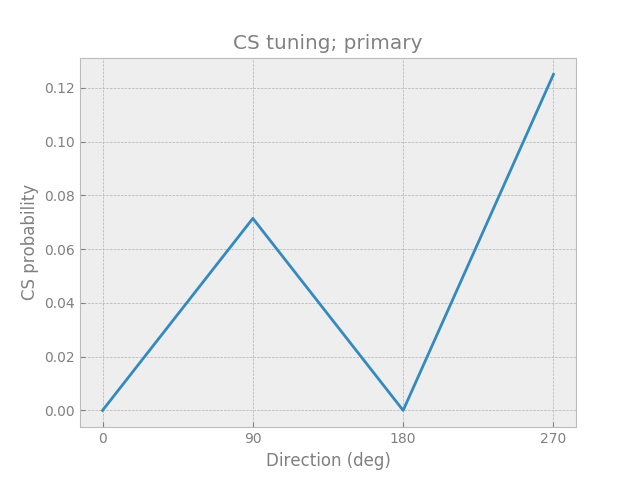

Text(0.5,1,u'CS tuning; primary')

In [42]:
plt.figure()
plt.plot(directions_prim, cs_probs_prim)
plt.xticks(directions_prim, directions_prim)
plt.xlabel('Direction (deg)')
plt.ylabel('CS probability')
plt.title('CS tuning; primary')

<IPython.core.display.Javascript object>


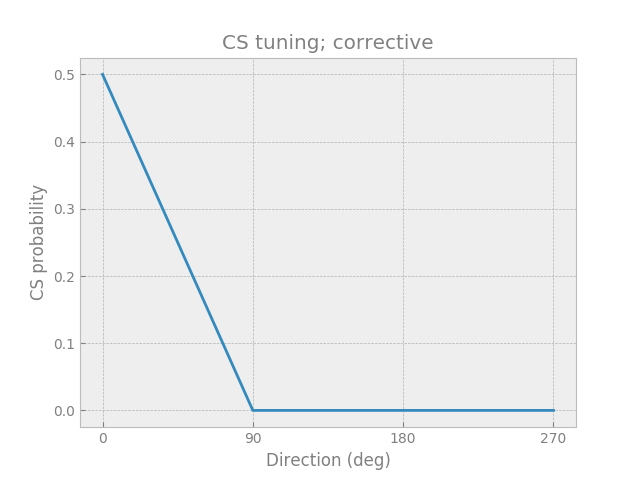

Text(0.5,1,u'CS tuning; corrective')

In [43]:
plt.figure()
plt.plot(directions_corr, cs_probs_corr)
plt.xticks(directions_corr, directions_corr)
plt.xlabel('Direction (deg)')
plt.ylabel('CS probability')
plt.title('CS tuning; corrective')

In [67]:
directions

array([  0,  45,  90, 135, 180, 225, 270, 315])